<a href="https://colab.research.google.com/github/SimonParadise/MPA-MLF-Buchta-228812/blob/main/MLF_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import os



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        ID  target
0        0       0
1        1       0
2        2       0
3        3       0
4        4       0
...    ...     ...
1486  1486       0
1487  1487       1
1488  1488       0
1489  1489       0
1490  1490       0

[1491 rows x 2 columns]
[[-32.78975806 -33.66255216 -42.78408663 ... -42.9729851  -47.77495765
  -51.46444886]
 [-36.14850423 -24.47784991 -37.15332085 ... -30.12584204 -37.42056165
  -44.91362907]
 [-27.32356387 -18.52198731 -47.62156099 ... -45.72037973 -35.23309178
  -46.91912813]
 ...
 [-57.92347075 -33.96766199 -23.01019239 ... -44.21303131 -31.66853983
  -46.04602257]
 [-48.13258362 -18.13003464 -42.17853777 ... -46.63100307 -39.81996065
  -47.23678696]
 [-36.37552058 -18.17781167 -38.81738332 ... -46.1900956  -31.99493091
  -51.8421336 ]]
(72, 48)


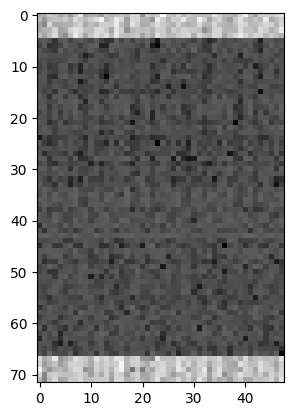

Min: -62.236156980222944
Max: 29.119300745664823


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# file paths
label_path = '/content/drive/MyDrive/MyDrive/MLF/MPA-MLF_DATA_NEW/label_train.csv'
npy_path = '/content/drive/MyDrive/MyDrive/MLF/MPA-MLF_DATA_NEW/Train'

# Load CSV file of labels for training
pd_dataset_train_label = pd.read_csv(label_path)
print(pd_dataset_train_label)

# load npy files for training
files = [f for f in os.listdir(npy_path)]

file_path = os.path.join(npy_path, files[426])  # Create the full path to the .npy file
data = np.load(file_path)

# print data
print(data)
print(data.shape)

# plotting 2D graph of values from one file
plt.imshow(data, cmap='binary')  # 'binary' gives a two-color map (black and white)
plt.show()

# checking for a range
print("Min:", data.min())
print("Max:", data.max())

# preparing list for the files from the Train folder
# Load each file and collect into a list
data_list = [np.load(os.path.join(npy_path, f)) for f in files]
#X_train_scaled =

#list_of_files = [np.load(folder_path + '/' + npy_file) for npy_file in npy_files]

In [4]:
# preparing list for the files from the Train folder
# Load each file and collect into a list
X_train = [np.load(os.path.join(npy_path, f)) for f in files]

# stack into array
X_train = np.stack(X_train)

# showing shape of X_train
print(X_train.shape)

# Flatten: (1491, 72, 48) → (1491, 72 * 48)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Standardize
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_train_flat)

# Reshape back: (1491, 72, 48)
X_scaled = X_scaled_flat.reshape(X_train.shape)

# showing shape of X_train scaled back after standardize
print(X_scaled.shape)

(1491, 72, 48)
(1491, 72, 48)


In [5]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       655,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,890 (2.57 MB)

 Trainable params: 674,890 (2.57 MB)

 Non-trainable params: 0 (0.00 B)